In [1]:
import pandas as pd
import numpy as np
from urllib.request import urlopen
import json
import plotly.express as px
import folium.plugins as plugins
import plotly.graph_objects as go
import folium
from folium.plugins import HeatMap
import pandas as pd
import folium
import xyzservices.providers as xyz
import matplotlib.pyplot as plt
import calendar

### Data loading

In [2]:
path = r"C:\Users\micha\OneDrive\Pulpit\DTU\S4\02806_Social\week1\Police_Department_Incident_Reports__Historical_2003_to_May_2018_20240129.csv"
data = pd.read_csv(path)
data['Date'] = pd.to_datetime(data['Date'])
data = data[~(data['Date'] > '2017-12-31')]

In [3]:
# after data exploration it tourns out that break-ins into cars can be from different categories,
# Burgraly and Larcent/Thefft, we filter them more to include only motor vehicle crimes 
# motor vehicles = cars and motorcycles
categories = ['BURGLARY', 'LARCENY/THEFT']
car_data = data[data['Category'].isin(categories)]
car_data['Time'] = pd.to_datetime(car_data['Time'],format= '%H:%M')
car_data['Hour'] = car_data['Time'].dt.hour
car_data['Year'] = (pd.to_datetime(car_data['Date'])).dt.year
print(car_data[['Category', 'Date', 'Hour','Year']].head())

print(f"All records from 2 categories: {len(car_data)}")

         Category       Date  Hour  Year
10       BURGLARY 2009-09-24    13  2009
11  LARCENY/THEFT 2012-12-21    19  2012
16  LARCENY/THEFT 2010-02-23    17  2010
19  LARCENY/THEFT 2012-02-06    18  2012
21  LARCENY/THEFT 2004-05-22    15  2004
All records from 2 categories: 553336


C:\Users\micha\AppData\Local\Temp\ipykernel_30448\1884684234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_data['Time'] = pd.to_datetime(car_data['Time'],format= '%H:%M')
C:\Users\micha\AppData\Local\Temp\ipykernel_30448\1884684234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_data['Hour'] = car_data['Time'].dt.hour
C:\Users\micha\AppData\Local\Temp\ipykernel_30448\1884684234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [4]:
# Get data only connected to vehicles
car_data = car_data[car_data['Descript'].str.contains('VEH')]
print(f"Motor vehicle records from 2 categories: {len(car_data)}")
print(car_data[['Category', 'Date', 'Descript']].head())

Motor vehicle records from 2 categories: 7939
           Category       Date                             Descript
115        BURGLARY 2010-11-26      BURGLARY, VEHICLE (ARREST MADE)
695   LARCENY/THEFT 2006-12-30  ATTEMPTED THEFT FROM LOCKED VEHICLE
1022  LARCENY/THEFT 2004-01-02  ATTEMPTED THEFT FROM LOCKED VEHICLE
1484  LARCENY/THEFT 2007-09-28  ATTEMPTED THEFT FROM LOCKED VEHICLE
2168  LARCENY/THEFT 2006-08-07  ATTEMPTED THEFT FROM LOCKED VEHICLE


In [5]:
# print(car_data[['Category', 'Date', 'PdDistrict', 'Hour', 'Year']].head())

## Create a timeseries 

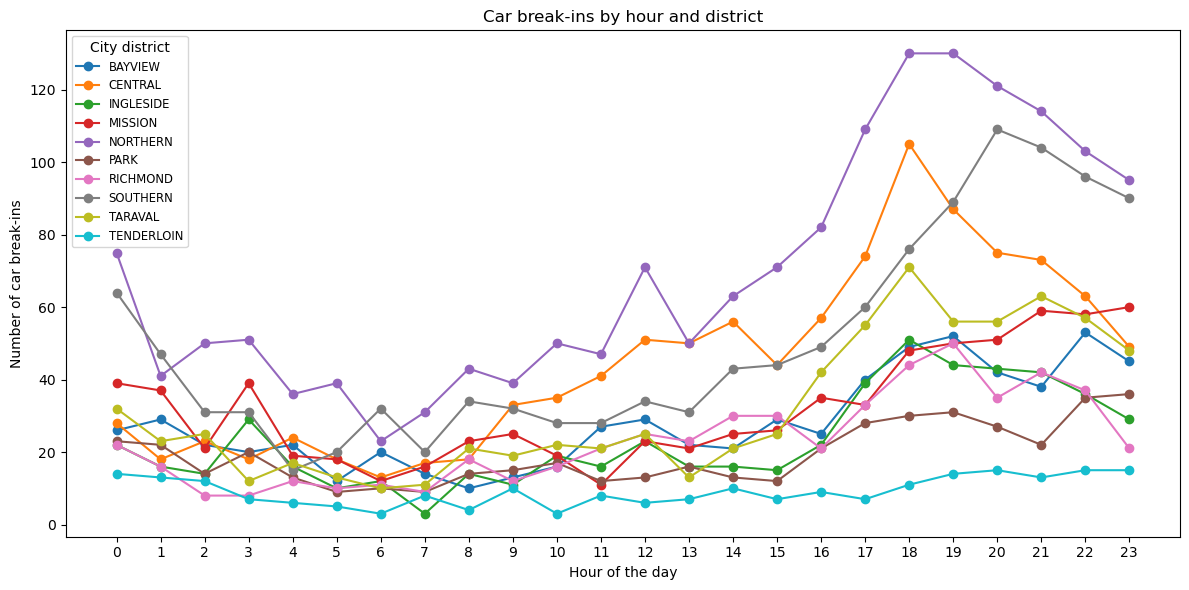

In [23]:
break_ins_by_hour_day = car_data.groupby(['Hour', 'PdDistrict']).size().unstack()

break_ins_by_hour_day.plot(figsize=(12, 6), marker='o')

plt.title('Car break-ins by hour and district')
plt.xlabel('Hour of the day')
plt.ylabel('Number of car break-ins')
plt.xticks(range(24))
plt.legend(title='City district', loc='upper left', fontsize='small')
plt.grid(False)

# Show the plot
plt.tight_layout()
# plt.show()
plt.savefig('break_ins_by_hour_and_PdDistrict.png')

### Description
Fig. X. Car break-ins by the hour and policing district.

The graph illustrates the frequency of car break-ins across different policing districts in San Francisco, shedding light on notable patterns and trends. A discernible trend emerges when looking into the hour-by-hour preferences, with the peak occurring between 17:00 and 19:00. This surge may be attributed to the static nature of parked vehicles during this time, presenting a reduced risk of detection. Notably, the Northern District emerges as the primary hotspot for car break-ins throughout the day, indicating a sustained prevalence of such incidents. Conversely, the Tenderloin District displays a consistent level of activity across all hours—a surprising finding given its reputation for heightened crime rates and perceived danger. One plausible explanation for this anomaly is that the Tenderloin serves as a residential area for a substantial number of individuals involved in criminal activities, potentially leading to a lower incidence of theft within the community.

source: https://goodmigrations.com/city-guides/san-francisco/tenderloin/#:~:text=Tenderloin%20NEIGHBORHOOD%20GUIDE,put%20up%20with%20its%20seediness.&text=The%20Tenderloin%20has%20a%20high,crime%20rate%20for%20San%20Francisco.



In [7]:
# # Group the data by 'Hour' and count the occurrences
# break_ins_by_hour = car_data['Hour'].value_counts().sort_index()

# # Plot the time series graph
# break_ins_by_hour.plot(figsize=(12, 6), marker='o')

# # Customize the plot
# plt.title('Break-ins Distribution by Hour')
# plt.xlabel('Hour of the Day')
# plt.ylabel('Number of Break-ins')
# plt.xticks(range(24))  # Set x-axis ticks for each hour
# plt.grid(True)

# # Show the plot
# plt.tight_layout()
# plt.show()

### Create a Map

In [13]:
# car_data_groupped = car_data.groupby(['PdDistrict']).size().reset_index(name='crime_count')
# car_data_max_val = max(car_data_groupped['crime_count'])
# car_data_min_val = min(car_data_groupped['crime_count'])
# print(f"Max value: {car_data_max_val}, min value: {car_data_min_val}")

# with urlopen('https://raw.githubusercontent.com/suneman/socialdata2022/main/files/sfpd.geojson') as response:
#     counties = json.load(response)
    
points_data = pd.DataFrame({
    "Location": ["Financial District", "North Beach", "The Embarcadero", "Nob Hill", "The Mission", "Pacific Heights", "PIER 39", "Golden Gate Park", "Union Square", "SoMa", "Civic Center", "Hayes Valley"],
    "Latitude": [37.7937, 37.7995, 37.7993, 37.7910, 37.7636, 37.7943, 37.8087, 37.7689, 37.7876, 37.7850, 37.7773, 37.7761],
    "Longitude": [-122.3965, -122.4089, -122.3977, -122.4174, -122.4174, -122.4349, -122.4098, -122.4830, -122.4066, -122.4005, -122.4196, -122.4296]
})


# # Create choropleth map
# fig = px.choropleth_mapbox(car_data_groupped, geojson=counties, locations='PdDistrict', color='crime_count',
#                            color_continuous_scale="Oranges",
#                            range_color=(car_data_max_val, car_data_min_val),
#                            mapbox_style="carto-positron",
#                            zoom=10.5, center = {"lat": 37.7749, "lon": -122.4194},
#                            opacity=0.5
#                           )

# # Add points to the map
# fig.add_scattermapbox(
#     mode="markers",
#     lon=points_data["Longitude"],
#     lat=points_data["Latitude"],
#     text=points_data["Location"],
#     marker=dict(size=7, color="blue")
# )

# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()

### Create a heatmap with tourist attractions and places to stay
### Play it how it changes bu hour of the day


In [12]:
# Create a Folium map centered around San Francisco
sf_map = folium.Map(location=[37.761000, -122.441394], zoom_start=13)

# Define the URL for Stamen Toner tiles with your API key
stamen_toner_url = 'https://tiles.stadiamaps.com/tiles/stamen_toner/{z}/{x}/{y}{r}.png?api_key=dba936f3-1ed1-4864-a3c0-f0b5f0f1ec3d'

# Add Stamen Toner tiles layer to the map
folium.TileLayer(
    tiles=stamen_toner_url,
    attr='Toner Background',
    name='Toner Background',
    max_zoom=18,
    min_zoom=1,
    subdomains='abcd'
).add_to(sf_map)

# Create a HeatMap layer using crime occurrences coordinates
heat_data = [[row['Y'], row['X']] for index, row in car_data.iterrows()]
plugins.HeatMap(heat_data, radius=6, blur=5).add_to(sf_map)

# Display the map
sf_map.save('sf_heatmap_with_stamen_toner.html')

In [22]:


# Create a Folium map centered around San Francisco
sf_map = folium.Map(location=[37.761000, -122.441394], zoom_start=12)

# Define the URL for Stamen Toner tiles with your API key
stamen_toner_url = 'https://tiles.stadiamaps.com/tiles/stamen_toner/{z}/{x}/{y}{r}.png?api_key=dba936f3-1ed1-4864-a3c0-f0b5f0f1ec3d'

# Add Stamen Toner tiles layer to the map
folium.TileLayer(
    tiles=stamen_toner_url,
    attr='Toner Background',
    name='Toner Background',
    max_zoom=18,
    min_zoom=1,
    subdomains='abcd'
).add_to(sf_map)

# Group car_data by hour
car_data['Hour'] = car_data['Time'].dt.hour

# Create HeatMapWithTime using grouped crime occurrences coordinates
heat_data_by_hour = []
for hour, data in car_data.groupby('Hour'):
    heat_data = [[row['Y'], row['X']] for index, row in data.iterrows()]
    heat_data_by_hour.append((hour, heat_data))

# Customizing each frame to include time and point count
time_indicators = [f'Time: {hour}:00' for hour, _ in heat_data_by_hour]

# Create HeatMapWithTime
heatmap_with_time = plugins.HeatMapWithTime(
    heat_data_by_hour,
    radius=11,
    min_opacity=0.5,
    max_opacity=0.8,
    use_local_extrema=True,
    min_speed=2.5,
    max_speed=6,
    speed_step=0.5,
    blur=0.7,
    index=time_indicators,
    auto_play=True 
)
pointColor='#1c3aff'

# Add custom points with customized marker icons to the map
for index, row in points_data.iterrows():
    icon = folium.map.Icon(color='cadetblue', icon_color='cadetblue', icon='map-pin')
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        icon=icon,
        popup=row['Location']
    ).add_to(sf_map)

# Add HeatMapWithTime to the map
heatmap_with_time.add_to(sf_map)

# Display the map
sf_map.save('sf_heatmap.html')



The heat map provides a compelling visualization of motor vehicle break-in incidents across San Francisco, revealing intriguing patterns. Figure X depicts the spatial distribution of these incidents overlaid on the city map. Notably, grey markers denote popular tourist attractions and recommended visitor destinations, primarily clustered in the east-north region of the city. This concentration aligns with the increasing rates of theft from motor vehicles, a concerning trend acknowledged by city officials [SOURCE]. The data suggests that these thefts are orchestrated by organized groups targeting tourist hubs, where valuable items are more likely to be stored in vehicles. Furthermore, the heat map highlights neighbouring areas surrounding popular tourist attractions, emphasizing their susceptibility to criminal activity—a finding corroborated by previous research [SOURCE].

source: https://www.cjcj.org/news/blog/san-franciscos-crime-wave-is-just-one-crime